# Import libraries

**All the imported libraries and functions were covered in the classes except the FunctionTransformer where I learnt about it from the following link:**
https://towardsdatascience.com/using-functiontransformer-and-pipeline-in-sklearn-to-predict-chardonnay-ratings-9b13fdd6c6fd

In [183]:
import pandas as pd 
import time  
## the NLP preprocessing libraries 
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer  
from nltk.corpus import stopwords 
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## The models libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import re
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
## The visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000

pd.set_option('display.max_colwidth',1000)

## Load data

In [184]:
Final_group = pd.read_csv('./Final_group.csv')

In [185]:
Final_group.head() # check the head and features 

,id,title,selftext,subreddit,label
0,prkskd,How to do keto when you cant cook,"Im a student and i live in a dorm and dont have access to the kitchen. I would love to cook, but i literally cant. Online i was looking for keto recipes that wouldnt require me to cook. I found some good ones such as those avocado salads and more salads. I can buy steamed chicken breast that is a package, and boiled eggs. Im also considering to eat the right nuts to fill in the remaining calories, which of course i would measure so i wouldnt go overboard with calories.\nSo im curious has anyone been through a similar situation and what did you eat? What did you buy? Or does anyone else have some no cook recipes to suggest? \nIm very new to keto and ive been doing research online and im fully ready to commit to it. Im trying to find more tools that would help me out\nOh and im considering getting an electric pot where u can make soups and stews(?), it is possible to make keto friendly foods with it?",keto,1
1,prkobp,Snack suggestions for vegetarians on keto?,"Hi there!\n\nI've been on keto for a month now and starting to crave something other than grilled veggies as snacks, any other suggestions?\n\nAlso, I'm from Canada and if you know of any brands that sell keto veggie snacks that'd be awesome!\n\nThanks!",keto,1
2,prkn15,Cholesterol//Keto love,"I'm like 16 days in. I read a negative article. Apparently doctors and nutritionists say Keto is the worst. I also know a nutritionist who ate loads of bacon (Dan The Bacon Man) who had his cholesterol tested for months and it was always normal, he proved this to his followers by actually showing the paperwork.\n\nWhat causes high cholesterol and should ketoers be worried about it since it's basically a lifestyle change for long term? \n\nYou can lower cholesterol by diet, correct? \n\nIs equating high cholesterol to Keto just flat out wrong? \n\nAlso... I ate a couple hundred grams of carbs yesterday, just to test what would happen. Suddenly had insomnia, heart burn, was constantly hungry, lazy, bad mood. Fuck all that noise. I ate *twice* today, avocado for breakfast and then dinner. Not hungry once. I love Keto. I'm loving the flavoured salt water a bit too much.",keto,1
3,prk3n8,Cheated on Keto and feel like absolute shit - in tears rn,[removed],keto,1
4,prk03h,I need help with a keto ice cream recipe please,"I’m following a recipe from a website specifically for keto and it called for 1/2 cup of Stevia/Erythritol so I bought a jar of what I thought was okay for keto sweetener from Publix called Keto:Sweet. The nutrition panel says it’s 0 calories, 0 fat, 0 carbs, 0 fiber, 0 sugar and a serving is 2 tsp. Have I been hoodwinked by this product!!!??????",keto,1


In [186]:
Final_group.shape

(10000, 5)

In [187]:
len(Final_group['id'].unique()) ##to make sure we have 10000 different posts

10000

In [188]:
Final_group.dtypes

id           object
title        object
selftext     object
subreddit    object
label         int64
dtype: object

 ## Exploratory Data Analysis
Here we are going to exploar our data by checking the null values, add the length and word counts for both the post content and the post title, plot the distrbution of the title and post content length for both subreddit to check if there is any relation. Also, we are going to extract the most common words in in the data to add them to the stop words which can improve our preprocessing and model performance.  

In [189]:
#get rid of links and line breaks
Final_group['selftext'] = Final_group['selftext'].replace('http\S+', 'link', regex=True).replace('www\S+', 'link', regex=True).replace('\n\n\S+', '', regex=True).replace('\n|S+', '', regex = True)
Final_group['title'] = Final_group['title'].replace('http\S+', 'link', regex=True).replace('www\S+', 'link', regex=True).replace('\n\n\S+', '', regex=True).replace('\n|S+', '', regex = True)

In [190]:
##check the null values 
Final_group.isnull().sum() 

id            0
title         0
selftext     93
subreddit     0
label         0
dtype: int64

**The only column that has null values is the selftext, the number of null value in the selftext in very small comparing to our data size, so we are going to drop the rows that has null values in the selftext.**

In [191]:
Final_group.dropna(subset = ["selftext"], inplace=True) ##drop the rows that have empty selftext  

In [192]:
Final_group.shape ##check the shape of the data after drop the null values

(9907, 5)

In [193]:
Final_group.isnull().sum() ##check the null values 

id           0
title        0
selftext     0
subreddit    0
label        0
dtype: int64

In [194]:
Final_group['Post_length'] = Final_group['selftext'].apply(lambda x: len(x)) ## Create a new column called `post_length` that contains the length of each post
Final_group['Title_length'] = Final_group['title'].apply(lambda x: len(x)) ## Create a new column called `title_length` that contains the length of each posts' title 

In [195]:
#### Create a new column called `title_word_count` that contains the number of words in each post title:
word_count = []
for post in Final_group['title']:
    count = post.split() ##split the post title to words 
    word_count.append(len(count))

Final_group['title_word_count'] = word_count

In [196]:
#### Create a new column called `post_word_count` that contains the number of words in each post:
word_count = []
for post in Final_group['selftext']:
    count = post.split() ##split the post title to words 
    word_count.append(len(count))

Final_group['post_word_count'] = word_count

In [197]:
Final_group.head() ##check the data head after adding the new columns

,id,title,selftext,subreddit,label,Post_length,Title_length,title_word_count,post_word_count
0,prkskd,How to do keto when you cant cook,"Im a student and i live in a dorm and dont have access to the kitchen. I would love to cook, but i literally cant. Online i was looking for keto recipes that wouldnt require me to cook. I found some good ones such as those avocado salads and more salads. I can buy steamed chicken breast that is a package, and boiled eggs. Im also considering to eat the right nuts to fill in the remaining calories, which of course i would measure so i wouldnt go overboard with calories.o im curious has anyone been through a similar situation and what did you eat? What did you buy? Or does anyone else have some no cook recipes to suggest? Im very new to keto and ive been doing research online and im fully ready to commit to it. Im trying to find more tools that would help me outOh and im considering getting an electric pot where u can make soups and stews(?), it is possible to make keto friendly foods with it?",keto,1,904,33,8,174
1,prkobp,nack suggestions for vegetarians on keto?,"Hi there! been on keto for a month now and starting to crave something other than grilled veggies as snacks, any other suggestions? I'm from Canada and if you know of any brands that sell keto veggie snacks that'd be awesome!",keto,1,225,41,6,41
2,prkn15,Cholesterol//Keto love,"I'm like 16 days in. I read a negative article. Apparently doctors and nutritionists say Keto is the worst. I also know a nutritionist who ate loads of bacon (Dan The Bacon Man) who had his cholesterol tested for months and it was always normal, he proved this to his followers by actually showing the paperwork. causes high cholesterol and should ketoers be worried about it since it's basically a lifestyle change for long term? can lower cholesterol by diet, correct? equating high cholesterol to Keto just flat out wrong? I ate a couple hundred grams of carbs yesterday, just to test what would happen. uddenly had insomnia, heart burn, was constantly hungry, lazy, bad mood. Fuck all that noise. I ate *twice* today, avocado for breakfast and then dinner. Not hungry once. I love Keto. I'm loving the flavoured salt water a bit too much.",keto,1,845,22,2,146
3,prk3n8,Cheated on Keto and feel like absolute shit - in tears rn,[removed],keto,1,9,57,12,1
4,prk03h,I need help with a keto ice cream recipe please,"I’m following a recipe from a website specifically for keto and it called for 1/2 cup of tevia/Erythritol so I bought a jar of what I thought was okay for keto sweetener from Publix called Keto:weet. The nutrition panel says it’s 0 calories, 0 fat, 0 carbs, 0 fiber, 0 sugar and a serving is 2 tsp. Have I been hoodwinked by this product!!!??????",keto,1,346,47,10,64


In [198]:
##check the longest and shortest posts' title

Final_group.sort_values(by='title_word_count', ascending=False, inplace=True)

In [199]:
Final_group.head(10)

,id,title,selftext,subreddit,label,Post_length,Title_length,title_word_count,post_word_count
5976,pbuqdq,"I want to share a personal story and a question about the unhealthy aspect of healthy eating - For once, I decided to say 'screw it' about my diet and simply wing it and ""live a little"" for a day. Guilt was creeping in but I really did not feel that guilty. It felt like a win and made me mindful.",[removed],nutrition,0,9,297,61,1
9656,nov21d,Is the take out the trash my good night inside another where did you go see ironing board my aren't we always the first I'm just a it's my new glad bright me and know the flawed in cranberry it's a girl didn't we see your sand is far away seventeen can my lost pictures will around my last midnight?,[removed],nutrition,0,9,299,60,1
7564,onbvzr,"have 30% body fat and my bench is weak as fuck literally 30kg (66lb). How can I lose body fat whilst increasing my bench and general strength, should I be in a caloric deficit or not? I'm 18 is that helps, I've gained. Lot of fat/weight over lockdown and lost muscle (I used to be able to bench 45kg)",[removed],nutrition,0,9,300,59,1
9697,no4utv,FOR MY FELLOW WEIGHTLIFTER !! - please help - i need to know if Green Giant broccoli and cheese is healthy to eat as a side with my usual chicken and rice (not counting the nutrition facts into my diet) the goal is to gain as much muscle as possible + lean down. is this healthy for bodybuilders?,[removed],nutrition,0,9,296,58,1
8805,o2z1sh,"What would you do in my position? I've been invited to participate in a study where I might have to take a pair of antibiotics (ciprofloxacin, 500mg twice daily, 7 days + Metronidazole, 500mg, 3x daily, 7 days). The compensation is $1,000. Is the money worth the hit to my gut biome? Would you do it?",[removed],nutrition,0,9,300,56,1
5455,pk585t,"Hey everyone, i have been trying to quit sugar for a while now but i just realized i cant have breakfast without any sweet. is it okay to eat 10 grams of honey every day ? i dont eat any sugar except that 10 grams of honey and some fruits. Goal: Getting down to %13 Bodyfat",[removed],nutrition,0,9,273,56,1
1451,pepca7,I'm not getting enough fiber in my diet. I eat vegetables but not as often as I should. Anyone know a low carb product I can get some fiber from? Most of the products are pretty high. One was the metamucil tablets with 2 g each but I was supposed to take 5 a day.,[removed],keto,1,9,263,55,1
5494,pji87e,"Fiber fermentation by gut microbiota into CFAs - is this a hidden source of calories - if so how substantial can it be? This is not to imply this is a bad thing as the butyric acid which gets produced for example has a lot of health benefits, but curious about the caloric impact.","As a side note, for anyone that's interested, see [link for more about butyric acid which is one of the short chain fatty acids that gets produced",nutrition,0,146,280,54,27
1042,piecgf,"After two years of unemployment, I've a job now, but I don't have the enough money to relocate to my new work location. Can somebody please lend me $130? I'll repay you as soon as I get my first paycheck. Please help me. I don't want to be stuck in this hellhole poverty forever.","I was literally applying to every job posting that I could see, and finally received an offer last week. This is just a mediocre job, but still it's a job nonetheless. I asked the HR if I could join from 2nd of next month, but she hung up on me saying it has to be before the end of this week or the offer would be valid no more. I literally feel like crying right now. I have very bad stuttering and it's really hard for me to convince any employer, and I don't know how long should I wait for an another job if I let go this offer. Can someone please lend me $130, it's just for my travel, the company told they'd provide me accommodation for this month. I felt awkward to ask them to pay for my travel as well and now I'm stuck in this awful situation. I really don't want to let this

In [200]:
Final_group.tail(10)

,id,title,selftext,subreddit,label,Post_length,Title_length,title_word_count,post_word_count
2680,p2tp1p,Goal,"this line with your question*Generated by [Keto Calculator](link 9.13* | CW 300 | 52% BF | Mostly sedentary 878 kcal Goal, a 62% deficit. (446 min, 2297 max)* 2g Carbohydrates* 42g Protein (87g min, 143g max)* 78g Fat (30g min, 235g max)",keto,1,238,4,1,42
2677,p2u054,Recipes,[removed],keto,1,9,7,1,1
2669,p2wl9t,Cholesterol,"This community was a great help when I dipped my toes into keto three or so years ago. I’ve carried on with a light touch keto and gotten weight down by 10-15# which for 70 yr old, short female is big help. definitely feel much better, have more energy and better mood with keto. I still work F/T. I also thought I was likely helping my cholesterol. news on the cholesterol scene after not going to dr for quite a few years yesterday was told cholesterol is 383 with LDL (bad one) at 304. not keen on drugs if avoidable and many years ago reduced cholesterol with diet and exercise but so long ago I don’t remember what I did. I thought keto stories abounded with better numbers for both diabetes and cholesterol but not seeing now. any suggestions? The keto macros help me feel good. I’m not going to give up cream and butter because my body functions better with it. But I have to pay attention to the latest blood numbers and change something. uggestions welcomed. am jogging almost daily...",keto,1,1164,11,1,213
2649,p35ehu,New,[removed],keto,1,9,3,1,1
4440,omsy9i,Contrave,"Hey keto people, won’t get into my whole history but just trust me when I say my keto journey has been LONG and frustrating. I have found some hormonal reasons it has not been very successful but fixing that has not really helped much. dont need any commentary on whether I should or shouldn’t resort to medication or any rude comments about weight loss meds/big pharma etc**** am now trying contrave and I would like to stay keto while taking contrave but I’m confused about the “take with low fat food” warning. Neither bupropion or naltrexone need food so why does this med? Does anyone here have experience or hear from their doc that they don’t really need to take with food? I would rather not take with food since I like to fast and this med needs to be taken twice a day. also love to hear about any experiences with keto and contrave together- good or bad! Thank you 💕",keto,1,879,8,1,162
6265,p74njx,sucavu.com/?wa=Koken,[removed],nutrition,0,9,20,1,1
2643,p3639b,Kombucha?,Before keto I liked to make my own kombucha and I've had this jar sitting in my kitchen for a while and it is soooo incredibly sour. I used one cup of sugar for a gallon but surely the scoby ate all the sugar? Right? It is not sweet whatsoever totally sour. Yay or nay?,keto,1,269,9,1,55
2593,p3qgfi,WHAT,[removed],keto,1,9,4,1,1
2564,p41xje,Cheated,[removed],keto,1,9,7,1,1
3090,oyy237,Opinion,[removed],keto,1,9,7,1,1


In [201]:
# Remove any post with empty title 
Final_group.drop(Final_group[Final_group['Title_length'] == 0].index, inplace = True)

In [202]:
Final_group.head()

,id,title,selftext,subreddit,label,Post_length,Title_length,title_word_count,post_word_count
5976,pbuqdq,"I want to share a personal story and a question about the unhealthy aspect of healthy eating - For once, I decided to say 'screw it' about my diet and simply wing it and ""live a little"" for a day. Guilt was creeping in but I really did not feel that guilty. It felt like a win and made me mindful.",[removed],nutrition,0,9,297,61,1
9656,nov21d,Is the take out the trash my good night inside another where did you go see ironing board my aren't we always the first I'm just a it's my new glad bright me and know the flawed in cranberry it's a girl didn't we see your sand is far away seventeen can my lost pictures will around my last midnight?,[removed],nutrition,0,9,299,60,1
7564,onbvzr,"have 30% body fat and my bench is weak as fuck literally 30kg (66lb). How can I lose body fat whilst increasing my bench and general strength, should I be in a caloric deficit or not? I'm 18 is that helps, I've gained. Lot of fat/weight over lockdown and lost muscle (I used to be able to bench 45kg)",[removed],nutrition,0,9,300,59,1
9697,no4utv,FOR MY FELLOW WEIGHTLIFTER !! - please help - i need to know if Green Giant broccoli and cheese is healthy to eat as a side with my usual chicken and rice (not counting the nutrition facts into my diet) the goal is to gain as much muscle as possible + lean down. is this healthy for bodybuilders?,[removed],nutrition,0,9,296,58,1
8805,o2z1sh,"What would you do in my position? I've been invited to participate in a study where I might have to take a pair of antibiotics (ciprofloxacin, 500mg twice daily, 7 days + Metronidazole, 500mg, 3x daily, 7 days). The compensation is $1,000. Is the money worth the hit to my gut biome? Would you do it?",[removed],nutrition,0,9,300,56,1


In [203]:
##check the longest and shortest posts
Final_group.sort_values(by='post_word_count', ascending=False, inplace=True)

In [204]:
Final_group.head(10)

,id,title,selftext,subreddit,label,Post_length,Title_length,title_word_count,post_word_count
9488,nrf3t5,50 eemingly Healthy Foods That Are Bad For You,"Microwave Popcorn so many light varieties of microwave popcorn on the market, it’s easy to think that this snack is healthy, but with high levels of sodium and the chemical diacetyl, some health professionals caution about making this a regular snack. better choice? a few plain kernels in a brown paper bag, and popping your own. You control the flavoring. alad Dressings you ever looked at the ingredient list on light salad dressings? They’re about a mile long! Filled with preservatives and other additives you can’t pronounce—not to mention sodium and sugar—you’re much better off drizzling your veggies with a little extra virgin olive oil and balsamic vinegar Mix Nuts And Dried Fruit mix is obviously a healthy choice, right? Wrong! While plain, natural mixes of unsalted nuts and unsweetened dried fruits can make for a good portion-controlled, high-energy snack, many mixes throw in chocolate chips, loads of salt, and added sugars. ince a small handful easily contains 300-plus calorie...",nutrition,0,16716,46,9,2853
601,pmaimd,"A step-by-step guide to setting up the Cronometer app (free version) with your Daily Macros (Calories, Net Carbs, Fat and Protein) and Electrolyte Targets (odium, Potassium, Magnesium).","Hi everyone, I have been doing Keto since the beginning of June and during that time I have been using Carb Manager to track my food and macros. However the free version doesn’t let you track your electrolytes because you can’t see how many milligrams of sodium, potassium or magnesium you have consumed from your food. I therefore decided to change to Cronometer this week because I was told that its free version showed this information but also that the macro and nutritional information in Cronometer is a lot more accurate than Carb Manager because unlike Cronometer, anyone using Carb Manager can create a food entry and enter nutritional values for it without any verification. took me a lot of trail and error to set up the Cronometer app with my macros and electrolyte targets so I thought that it would be useful to share the step-by-step process here for anyone else who wants to get started using Cronometer. All review comments welcomed, so let me know if I’ve made any mistakes. up ...",keto,1,13526,185,27,2362
4462,omjlbv,My journey with Keto diet and how I lost more than 30 kilograms in less than 3 months,"Hello, I just wanted to share my experience with a keto diet that I followed. o I am 24 years old. In recent years I started gaining a lot of weight, I was to 70 kilograms and then my weight reached 95 kilograms. A lot of changes happened to my body because of that. I got a second chin, I got huge face etc. o I started doing exercises and trying to limit the amount of calories I take but I didn't feel that it helped enough. I only lost 2 kilograms and it took me a lot of exercise and a lot of time and effort. I then searched google for the best way to lose weight in a short period of time and that's how I found the keto diet. I was 92 kilograms and I became 58 kilograms. I completely lost my second chin. My face became soo thin. People who know me where so concerned about me because my face and my body really changed. I wish I can show you the before and after photos of my face. It is insane how much I changed and I was really happy about that but there are some disadvantages which...",keto,1,10061,85,18,2008
5039,pr3zju,A brief overview why cholesterol (LDL) is implicated in the etiology of heart disease,"Here's why I believe that cholesterol is implicated in the etiology of heart disease often see articles or post by people who are skeptic that dietary cholesterol and serum cholesterol play an important role in the initiation and progression of coronary artery diseases. Here’s why I believe that dietary cholesterol and high serum cholesterol do increase cardiovascula

In [205]:
Final_group.tail(100)

,id,title,selftext,subreddit,label,Post_length,Title_length,title_word_count,post_word_count
6413,p53kxt,Which form of salt is the healthiest?,[removed],nutrition,0,9,37,7,1
6599,p2kf43,Best Diet to Help Maximize Life Expectancy?,[removed],nutrition,0,9,43,7,1
8180,od3xle,Can a lot of fruit replace vegetables?,[removed],nutrition,0,9,38,7,1
4987,ohbndc,Are horseradish sauce and au jus keto-friendly?,[removed],keto,1,9,47,7,1
2362,p5s70z,Beginner question about 20 grams of carbs,[removed],keto,1,9,41,7,1
6605,p2i24m,I think I have a watermelon problem.,[removed],nutrition,0,9,36,7,1
5124,ppio8d,"nacks before a meal, timing and info?",[removed],nutrition,0,9,37,7,1
9290,nugccy,Been stuck at a certain weight level....,[removed],nutrition,0,9,40,7,1
6357,p5rqmv,How to gain weight for skinny guy.,[removed],nutrition,0,9,34,7,1
2444,p531nq,anyone tried alginate egg noodles like these?,[removed],keto,1,9,45,7,1


**From the above data exploration we can notice that the tilte length of both subreddits are mainly in the same range which mean that the title length coudn't help with classifying the posts. Also, we can notice that there is a lot of selftext indicates by ['removed]' these posts might be pictures or videos and doesn't contain text. To check the correctness of these claims, we are going to plot the distribution of word counts for both the tilte and self text of both subreddits. We removed all the post with blank title **

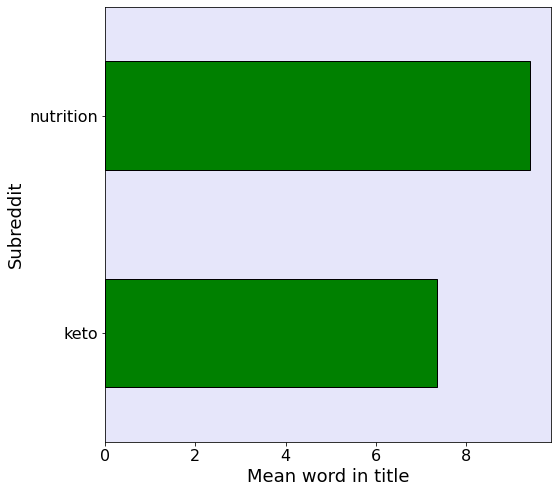

In [206]:
sns.set_style(rc={'axes.facecolor':'lavender', 'figure.facecolor':'w'})
Final_group.groupby('subreddit').mean()[['title_word_count']].plot(kind='barh', figsize=(8,8), facecolor='g', edgecolor='k', fontsize=18, legend=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Mean word in title',fontsize=18)
plt.ylabel('Subreddit',fontsize=18)
for pos in ['top', 'bottom', 'right', 'left']:
    plt.gca().spines[pos].set_edgecolor('k');

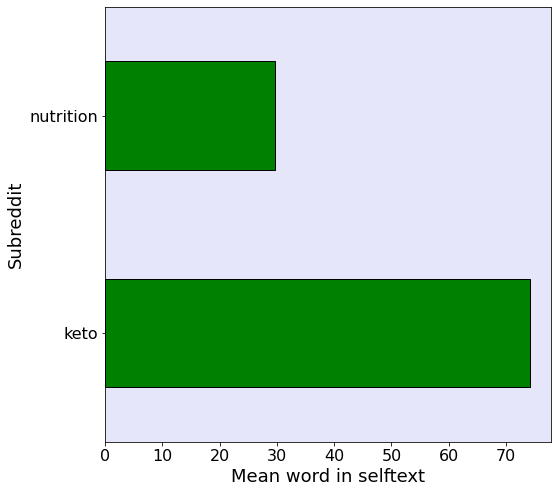

In [207]:
sns.set_style(rc={'axes.facecolor':'lavender', 'figure.facecolor':'w'})
Final_group.groupby('subreddit').mean()[['post_word_count']].plot(kind='barh', figsize=(8,8), facecolor='g', edgecolor='k', fontsize=18, legend=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Mean word in selftext',fontsize=18)
plt.ylabel('Subreddit',fontsize=18)
for pos in ['top', 'bottom', 'right', 'left']:
    plt.gca().spines[pos].set_edgecolor('k');

**plot the distrbution of the title_word_counts and get the statistics summary based on the subreddit**

In [208]:
Final_group.groupby("subreddit")["title_word_count"].mean() ##find mean title_word_count for both subreddits

subreddit
keto         7.357042
nutrition    9.417071
Name: title_word_count, dtype: float64

In [209]:
Final_group.groupby("subreddit")["title_word_count"].max() ##find max title_word_count for both subreddits

subreddit
keto         55
nutrition    61
Name: title_word_count, dtype: int64

In [210]:
Final_group.groupby("subreddit")["title_word_count"].min() ##find min title_word_count for both subreddits

subreddit
keto         1
nutrition    1
Name: title_word_count, dtype: int64

Text(0, 0.5, 'Number of posts')

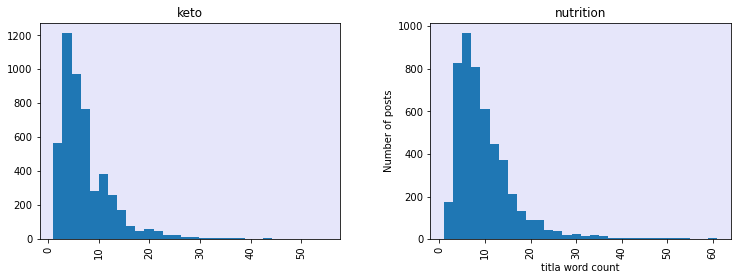

In [211]:
Final_group.hist(column='title_word_count', by='subreddit',figsize=(12, 4),
        bins=30)
plt.xlabel('titla word count')
plt.ylabel('Number of posts')


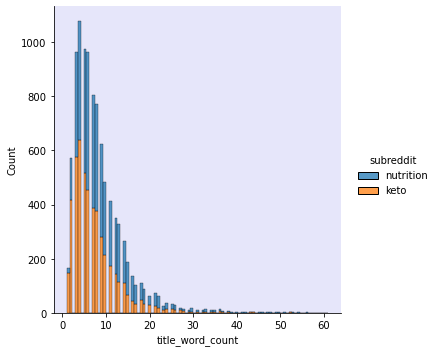

In [212]:
##plot the hist for the title_word_count for both subredditds on the same plot to make it easier for comparason
sns.displot(Final_group, x = "title_word_count", hue="subreddit",multiple="stack") 

In [213]:
Final_group.groupby("subreddit")["post_word_count"].mean() ##find mean post_word_count for both subreddits

subreddit
keto         74.200887
nutrition    29.725930
Name: post_word_count, dtype: float64

In [214]:
Final_group.groupby("subreddit")["post_word_count"].max() ##find max post_word_count for both subreddits

subreddit
keto         2362
nutrition    2853
Name: post_word_count, dtype: int64

In [215]:
Final_group.groupby("subreddit")["post_word_count"].min() ##find min post_word_count for both subreddits

subreddit
keto         1
nutrition    1
Name: post_word_count, dtype: int64

array([<AxesSubplot:title={'center':'keto'}>,
       <AxesSubplot:title={'center':'nutrition'}>], dtype=object)

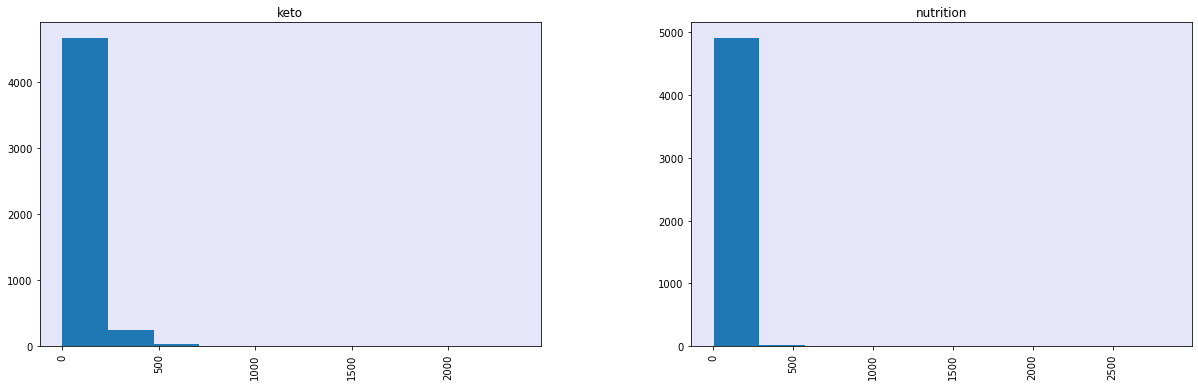

In [219]:
Final_group.hist(column='post_word_count', by='subreddit',figsize=(20, 6),grid=True)

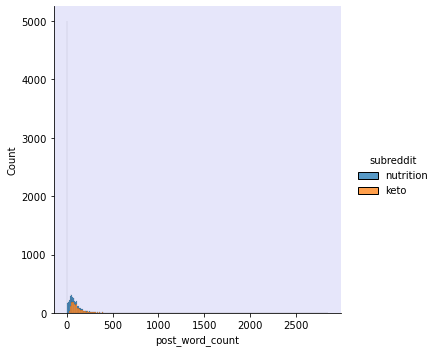

In [220]:
sns.displot(Final_group, x = "post_word_count", hue="subreddit",multiple="stack")

In [104]:
##check how many posts has 1 word length
Final_group.loc[(Final_group['post_word_count'] == 1)]


,id,title,selftext,subreddit,label,Post_length,Title_length,title_word_count,post_word_count
3022,oznkac,"Posting this with sincerity: I’ve noticed many paleo, keto, advocates are still overweight or don’t appear very healthy. Looking at the plant-based doctors and advocates…they’re all slender. Does anyone have any insight?",[removed],keto,1,9,220,32,1
6412,p53vy7,I'm intolerant to eggs.,[removed],nutrition,0,9,23,4,1
4150,op4vqb,A detailed guide to the potential health benefits and risks of the keto diet,[removed],keto,1,9,76,14,1
5036,pr5kz0,M26: tarting to worry that being brought up vegan has made me ill,[removed],nutrition,0,9,65,13,1
2395,p5i5ba,Hit the dollar tree.,[removed],keto,1,9,20,4,1
...,...,...,...,...,...,...,...,...,...
4713,ojyoc6,New to keto and noticing benefits!,[removed],keto,1,9,34,6,1
9513,nr0yzl,Nutrition books or online courses recommendation,[removed],nutrition,0,9,48,6,1
1296,pg2pya,A poonful of Peanut Butter Makes the ugar Pangs Go Away.,[removed],keto,1,9,56,11,1
6484,p49d4m,Food that 'works for you' does not necessarily work for you,[removed],nutrition,0,9,59,11,1


**Find the most common words in the post title and post content**

In [106]:
#initate the countervectorized, use all defult parameters except the stop_words and max_feature 
cvec = CountVectorizer(stop_words='english', max_features=4000) 

In [221]:
# common words in title
Clean_posts_title = Final_group['title']
#transform thr post tiltles
Clean_posts_title_cvec = cvec.fit_transform(Clean_posts_title) 
df_Clean_posts_title = pd.DataFrame(Clean_posts_title_cvec.todense(), columns = cvec.get_feature_names()) ##make a dataframe 
df_Clean_posts_title['subreddit'] = Final_group ['subreddit']
#filter a new DataFrame for keto title 
df_keto_title = df_Clean_posts_title[df_Clean_posts_title['subreddit'] == 'keto']
#filter a new DataFrame for Nutrition title 
df_nutrition_title = df_Clean_posts_title[df_Clean_posts_title['subreddit'] == 'nutrition']
#drop the sureddit (not np)
df_keto_title.drop(['subreddit'], axis = 1, inplace = True)
df_nutrition_title.drop(['subreddit'], axis = 1, inplace = True)
df_Clean_posts_title.drop(['subreddit'], axis = 1, inplace = True)
df_Clean_posts_title.head() ##check the head 

C:\Users\Malek\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


000  01  02  03  04  06  07  08  09  0g  10  100  1000  1000mg  100g  \
0    0   0   0   0   0   0   0   0   0   0   0    0     0       0     0   
1    0   0   0   0   0   0   0   0   0   0   0    0     0       0     0   
2    0   0   0   0   0   0   0   0   0   0   0    0     0       0     0   
3    0   0   0   0   0   0   0   0   0   0   0    0     0       0     0   
4    0   0   0   0   0   0   0   0   0   0   0    0     0       0     0   

   100lbs  100ml  10k  10lbs  11  110  114  12  120  1200  13  130  1300  14  \
0       0      0    0      0   0    0    0   0    0     0   0    0     0   0   
1       0      0    0      0   0    0    0   0    0     0   0    0     0   0   
2       0      0    0      0   0    0    0   0    0     0   0    0     0   0   
3       0      0    0      0   0    0    0   0    0     0   0    0     0   0   
4       0      0    0      0   0    0    0   0    0     0   0    0     0   0   

   140  1444  14g  14lbs  15  150  1500  1500cal  150g  150lb  151  16  160  \
0    0     0    0      0   0    0     0        0     0      0    0   0    0   
1    0     0    0      0   0    0     0        0     0      0    0   0    0   
2    0     0    0      0   0    0     0        0     0      0    0   0    0   
3    0     0    0      0   0    0     0        0     0      0    0   0    0   
4    0     0    0      0   0    0     0        0     0      0    0   0    0   

   16g  17  170  170lbs  172  175  175lbs  17m  18  180  19  190  190lbs  196  \
0    0   0    0       0    0    0       0    0   0    0   0    0       0    0   
1    0   0    0       0    0    0       0    0   0    0   0    0       0    0   
2    0   0    0       0    0    0       0    0   0    0   0    0       0    0   
3    0   0    0       0    0    0       0    0   0    0   0    0       0    0   
4    0   0    0       0    0    0       0    0   0    0   0    0       0    0   

   1g  1lb  1st  20  200  2000  200g  2016  2018  2020  2021  2022  205  20f  \
0   0    0    0   0    0     0     0     0     0     0     0     0    0    0   
1   0    0    0   0    0     0     0     0     0     0     0     0    0    0   
2   0    0    0   0    0     0     0     0     0     0     0     0    0    0   
3   0    0    0   0    0     0     0     0     0     0     0     0    0    0   
4   0    0    0   0    0     0     0     0     0     0     0     0    0    0   

   20g  20lbs  21  21day  22  225  227  23  24  240  240lbs  241  245  25  \
0    0      0   0      0   0    0    0   0   0    0       0    0    0   0   
1    0      0   0      0   0    0    0   0   0    0       0    0    0   0   
2    0      0   0      0   0    0    0   0   0    0       0    0    0   0   
3    0      0   0      0   0    0    0   0   0    0       0    0    0   0   
4    0      0   0      0   0    0    0   0   0    0       0    0    0   0   

   250  2500  25g  26  27  28  2g  2kg  2lbs  2mad  2nd  30  300  3000  30g  \
0    0     0    0   0   0   0   0    0     0     0    0   0    0     0    0   
1    0     0    0   0   0   0   0    0     0     0    0   0    0     0    0   
2    0     0    0   0   0   0   0    0     0     0    0   1    0     0    0   
3    0     0    0   0   0   0   0    0     0     0    0   0    0     0    0   
4    0     0    0   0   0   0   0    0     0     0    0   0    0     0    0   

   30lbs  30secs  31  32  320  33  35  36  360  37  38  3l  3rd  3s  3x  40  \
0      0       0   0   0    0   0   0   0    0   0   0   0    0   0   0   0   
1      0       0   0   0    0   0   0   0    0   0   0   0    0   0   0   0   
2      0       0   0   0    0   0   0   0    0   0   0   0    0   0   0   0   
3      0       0   0   0    0   0   0   0    0   0   0   0    0   0   0   0   
4      0       0   0   0    0   0   0   0    0   0   0   0    0   0   0   0   

   40g  40lbs  40s  41  42  44  45  45g  45kg  47  48  48h  49  4g  4kg  50  \
0    0      0    0   0   0   0   0    0     0   0   0    0   0   0    0   1   
1    0      0    0   0   0   0   0    0     0   0   0    

In [222]:
# common words in self text
Clean_posts = Final_group['selftext']
Clean_posts_cvec = cvec.fit_transform(Clean_posts) ##transform the post 
df_Clean_posts = pd.DataFrame(Clean_posts_cvec.todense(), columns = cvec.get_feature_names()) ##make a dataframe 
df_Clean_posts['subreddit'] = Final_group ['subreddit']
#filter a new DataFrame for keto content 
df_keto_content = df_Clean_posts[df_Clean_posts['subreddit'] == 'keto']
#filter a new DataFrame for Nutrition content 
df_nutrition_content = df_Clean_posts[df_Clean_posts['subreddit'] == 'nutrition']
#drop the sureddit (not np)
df_keto_content.drop(['subreddit'], axis = 1, inplace = True)
df_nutrition_content.drop(['subreddit'], axis = 1, inplace = True)
df_Clean_posts.drop(['subreddit'], axis = 1, inplace = True)
df_Clean_posts.head() ##check the head 

C:\Users\Malek\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


00  000  02  0g  10  100  1000  1000mg  100g  100lbs  103  10g  10k  10lbs  \
0   0    0   0   0   1    3     0       0     0       0    0    0    0      0   
1   0    2   0   0   2    0     0       0     0       0    0    0    0      0   
2   4    0   0   0   0    0     0       0     0       0    0    0    0      0   
3   0    0   0   0   2    0     0       0     0       0    0    0    0      0   
4   0    0   0   0   0    0     0       0     0       0    0    0    0      0   

   11  110  1100  11g  12  120  1200  120g  123  125  12g  12pm  13  130  \
0   0    0     0    0   0    0     0     0    0    0    0     0   0    0   
1   2    0     0    0   0    0     0     0    0    0    0     0   2    0   
2   0    0     0    0   0    0     0     0    0    0    0     0   0    0   
3   0    0     0    0   1    0     0     0    0    0    0     0   1    0   
4   0    0     0    0   0    0     0     0    0    0    0     0   0    0   

   1300  135  136  14  140  1400  143  145  149  14g  15  150  1500  150g  \
0     0    0    0   0    0     0    0    0    0    0   1    0     0     0   
1     0    0    0   0    0     0    0    0    0    0   1    0     0     0   
2     0    0    0   0    0     0    0    0    0    0   0    0     0     0   
3     0    0    0   0    0     0    0    0    0    0   0    1     0     0   
4     0    0    0   0    0     0    0    0    0    0   0    1     0     0   

   155  156  15g  15lbs  16  160  1600  163  165  165lbs  17  170  1700  \
0    0    0    0      0   0    0     0    0    0       0   0    0     0   
1    0    0    0      0   0    0     0    0    0       0   0    0     0   
2    0    0    0      0   0    0     0    0    0       0   0    0     0   
3    0    0    0      0   0    0     0    0    0       0   0    0     0   
4    0    0    0      0   0    0     0    0    0       0   0    0     0   

   170lbs  175  17g  18  180  1800  180g  180lbs  185  188  18g  19  190  193  \
0       0    0    0   0    0     0     0       0    0    0    0   0    0    0   
1       0    0    0   0    0     0     0       0    0    0    0   0    0    0   
2       0    0    0   0    0     0     0       0    0    0    0   0    0    0   
3       0    0    0   0    0     0     0       0    0    0    0   1    0    0   
4       0    0    0   0    0     0     0       0    0    0    0   0    0    0   

   195  196  197  198  199  1g  1k  1kg  1lb  1st  20  200  2000  2008  200g  \
0    0    0    0    0    0   0   0    0    0    0   0    1     0     0     0   
1    0    0    0    0    0   0   0    0    0    0   1    0     0     0     0   
2    0    0    0    0    0   0   0    0    0    0   1    0     0     0     0   
3    0    0    0    0    0   0   0    0    0    0   0    0     0     0     0   
4    0    0    0    0    0   0   0    0    0    0   0    0     0     0     0   

   2016  2017  2018  2019  2020  2021  205  20g  20lbs  20s  21  210  215  22  \
0     0     0     0     0     0     0    0    0      0    0   0    0    0   0   
1     0     0     0     0     0     0    0    1      0    0   0    0    0   0   
2     0     0     0     0     0     0    0    0      0    0   0    0    0   0   
3     0     0     0     0     0     0    0    0      0    0   0    0    0   0   
4     0     0     0     0     0     0    0    0      0    0   1    0    0   0   

   220  225  23  230  235  24  240  245  248  25  250  2500  255  25g  26  \
0    0    0   0    0    0   0    0    0    0   0    0     0    0    0   0   
1    0    0   0    0    0   0    0    0    0   0    0     0    0    0   0   
2    0    0   0    0    0   1    0    0    0   0    0     0    0    0   0   
3    0    0   0    0    0   0    0    0    0   0    0     0    0    0   0   
4    0    0   0    0    0   0    0    0    0   1    0     0    0    0   0   

   265  27  270  275  28  280  29  2g  2lbs  2nd  2x  30  300  3000  300g  \
0    0   0    0    0   0    0   0   0     0    0   0   0    1     0     0   
1    0   0    0    0   0    0   0   0     0    0   0   0    0     0     0

Text(0.5, 1.0, 'Most common words in the posts title')

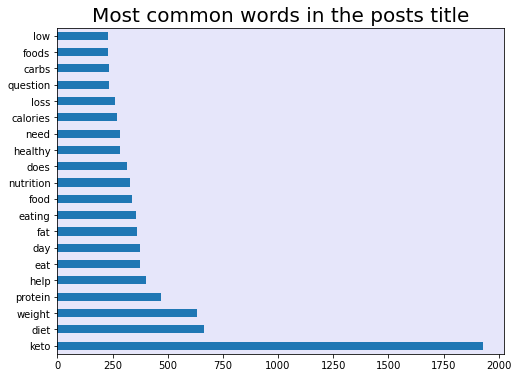

In [223]:
##show the 20 most common words in the posts title
df_Clean_posts_title.sum().sort_values(ascending = False).head(20).plot(kind='barh', figsize=(8, 6)) 
plt.title('Most common words in the posts title', fontsize=20)

In [224]:
df_Clean_posts_title.sum().sort_values(ascending = False).head(20) # most common word in both keto & nut /title

keto         1927
diet          662
weight        632
protein       468
help          403
eat           375
day           373
fat           362
eating        357
food          337
nutrition     331
does          316
healthy       282
need          282
calories      270
loss          260
question      235
carbs         232
foods         228
low           227
dtype: int64

Text(0.5, 1.0, 'Most common words in the posts content')

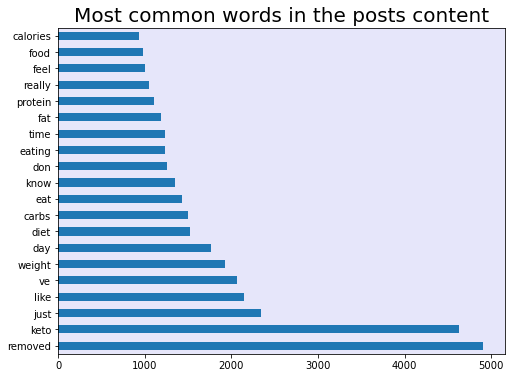

In [225]:
##show the 20 most common words in the posts content
df_Clean_posts.sum().sort_values(ascending = False).head(20).plot(kind='barh', figsize=(8, 6)) 
plt.title('Most common words in the posts content', fontsize=20)

In [226]:
df_Clean_posts.sum().sort_values(ascending = False).head(20) # most common word in both keto & nut /content

removed     4909
keto        4627
just        2341
like        2142
ve          2061
weight      1927
day         1769
diet        1517
carbs       1504
eat         1430
know        1354
don         1260
eating      1234
time        1233
fat         1191
protein     1102
really      1048
feel        1004
food         975
calories     938
dtype: int64

### Check the most common words in the posts title for each subreddit

Text(0.5, 1.0, 'Most common words in the KETO posts title')

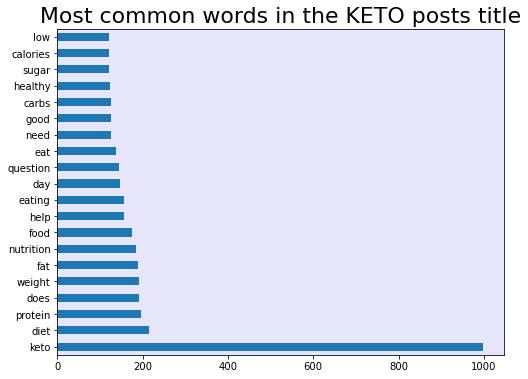

In [227]:
#common word by (keto, title)
df_keto_title.sum().sort_values(ascending = False).head(20).plot(kind='barh', figsize=(8, 6)) 
plt.title('Most common words in the KETO posts title', fontsize=22)

In [228]:
df_keto_title.sum().sort_values(ascending = False).head(10) # all the most common word in keto / title

keto         997
diet         214
protein      197
does         192
weight       191
fat          190
nutrition    185
food         174
help         157
eating       155
dtype: int64

Text(0.5, 1.0, 'Most common words in the NUTRITION post title')

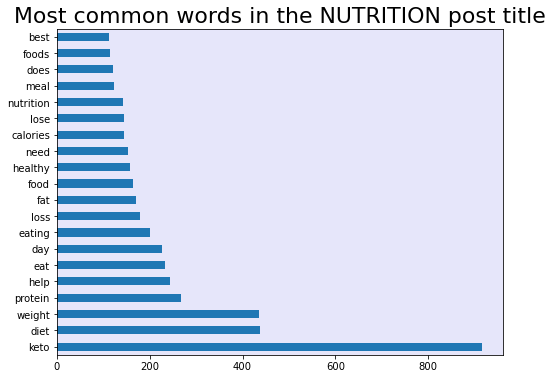

In [229]:
#common word by (nutrition, title)
df_nutrition_title.sum().sort_values(ascending = False).head(20).plot(kind='barh', figsize=(8, 6)) 
plt.title('Most common words in the NUTRITION post title', fontsize=22)

In [230]:
df_nutrition_title.sum().sort_values(ascending = False).head(10) # all the most common word in nut / title

keto       916
diet       438
weight     436
protein    267
help       243
eat        232
day        226
eating     200
loss       179
fat        170
dtype: int64

### Check the most common words in the posts content for each subreddit

Text(0.5, 1.0, 'Most common words in the KETO posts content')

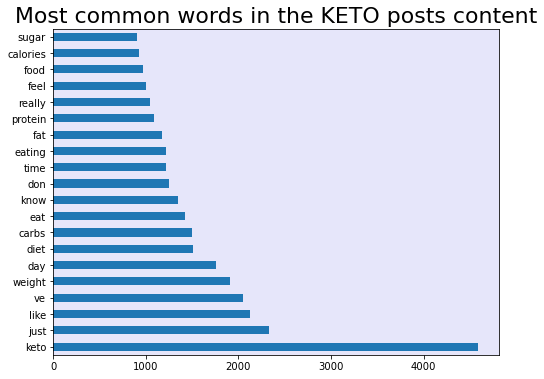

In [231]:
#common word by (keto, title)
df_keto_content.sum().sort_values(ascending = False).head(20).plot(kind='barh', figsize=(8, 6)) 
plt.title('Most common words in the KETO posts content', fontsize=22)

In [232]:
df_keto_content.sum().sort_values(ascending = False).head(10) # all the most common word in keto / content

keto      4590
just      2328
like      2130
ve        2046
weight    1914
day       1761
diet      1508
carbs     1495
eat       1423
know      1345
dtype: int64

Text(0.5, 1.0, 'Most common words in the NUTRITION posts content')

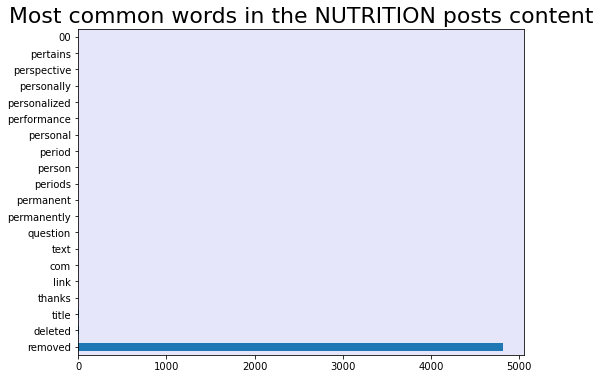

In [233]:
#common word by (nutrition, title)
df_nutrition_content.sum().sort_values(ascending = False).head(20).plot(kind='barh', figsize=(8, 6)) 
plt.title('Most common words in the NUTRITION posts content', fontsize=22)

In [234]:
df_nutrition_content.sum().sort_values(ascending = False).head(10) # all the most common word in nut / content

removed        4819
deleted          14
title             5
thanks            2
link              2
com               1
text              1
question          1
permanently       0
permanent         0
dtype: int64

**we can notice that most of the  Nutrition posts content were replaced by thre word removed**

**From the above data exploration we can conclude the following points:**
- There is no notice difference in the title_word_count between the two subreddits. This feature does not give much information about the post, so we can exclude it from the features been used for the classification.
- There is no notice differeance in the distrbution of the post_words_count for both subreddits. This features has nothing to do witht the classification model, as it will not add any information help with determine the subreddit that the post coming from. 
- When applied the defult CountVectorizer with 'english' stop words, we found some other common words in both the post_title and the post_content, we re going to add these words to the stop_words list except two words "keto" and "nutrition". These two words refer directly to the subreddits, so we are going to keep them.
- Also from the common words in the post content, we noticed that the word "removed" has been used alot about 4909 times. The explination of this is that, some posts contain images or Videos in the post content and when we fetched the posts these images and videos were removed and replaced by the word "removed".
- There is some post without title, but they are very little compare to our data set, about 16 posts only.

**Based on the conclusion points from the data exploration we are going to do this:**
- Use the post_title and the post_words_count as features for the classification model and see how the model performs.
- Costumize the stop_words list by adding the common words we have found.


## NLP and data setup and Models Preparation 

Now we know what features we want to use to classify the posts, so this is the time to setup our training and testing data, and define the nlp 

## Set up our data for modeling
X will be the title and the title and the selftext, we are going to use each one alone.
Y will be the lables (0 for nutrition and 1 for keto)

In [235]:
X= Final_group[['title','selftext']]
y = Final_group['label']

In [236]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [237]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape  ##check the shape of the train and test data

((6637, 2), (3270, 2), (6637,), (3270,))

In [238]:
## Baseline accuracy, calculate baseline accuracy in order to tell if our model is better than null model.
y_train.value_counts(normalize = True)

1    0.500979
0    0.499021
Name: label, dtype: float64

**The Baseline accuracy is 0.5009, our model should have accuracy more than 0.5009 to say it is better than the null model.**

## NLP Data Pre-Processing

We are going to pre_proccess the text data before entiring it to the predection model. For this step we are going to use some methods from the Natural Language Processing such as the following methods:

- Convert the letter to lowercase letters
- Remove special characters
- Tokenizing (Split the text into words)
- Stemming (get back the base form of the word)
- Stop word removal (remove the most occure words in the text)

To make it easier to us, we are going to define coustmize token_stemmer class that does the first 4 points of the pre_processing and use this class when using the vectorizer. Also, we are going to make a coustomize stop_words list that contains the "english" stop_word is addition to the most common words we found the EDA section.

**Coustmize the Token_stemmer and the Stop_word** 

In [239]:
##Define a costume tokenizer and Stemmer class, split the doc to words only (remove the spical characters and the numbers) and convert the letters to lowercase, then return the base form of the word   
tokenizer = RegexpTokenizer('[a-z]\w+')
class  StemmerWordTokenizer:
    tokenizer = RegexpTokenizer('[a-z]\w+') ##remove spcial characters and only keep the words  
    def __init__(self):
         self.Ste = PorterStemmer() ##call the stemmer
    def __call__(self, doc):
        return [self.Ste.stem(t) for t in tokenizer.tokenize(doc.lower())]

In [241]:
## before doing the preprocessing we are going to add more words to the stop words that is mutual between the two subreddits
my_stop_word = ['eat', 'diet','weight','food', 'protein', 'help','fat','health','need','calorie', ]
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_word)

## Modeling
For the modling we are going to use logistic regression, Multinomial Naive Bayes (as we are dealing with possitive integers data) and Random Forests. Also, we are going to alternate between the two vectorizer ( counterVictorizer and the (TF-IDF) Vectorizer).
For the predictor, we have two options:
- use the post content (selftext) alone
- use the post title alone 
We have 12 different combinations of the classifiers, vectorizers and the predictors. In this step we are going to define each model, use pipline and RandomizedSearchCV( instead of GridSearchCV to cut down on time spent on hyperparameter tuning)to find the best paramters for the model, fit the train data. The model score and the confusion matrix will be considered in the models scores and comparisons step. 

In [242]:
##To make it easy for us we define a function that take the model and the predictor along with the vectorizer and the parameters and do the pipline and the gridsearch
from sklearn.preprocessing import FunctionTransformer
def Pipe_gs(model,classifier, vectorizer_name,vectorizer, predictor,pipe_params,model_name):
     pipe = Pipeline([('selector', FunctionTransformer(lambda x:x[predictor], validate=False)),
    (vectorizer_name,vectorizer),
    (classifier, model)])
     gs = RandomizedSearchCV(pipe,
                  pipe_params,n_iter = 5,
                cv =5) 
     gs.fit(X_train, y_train)
     print(model_name,'train_score:', gs.score(X_train, y_train))
     print(model_name,'test_score:', gs.score(X_test, y_test))
     print(model_name,'best_Parameters:', gs.best_params_)
     return gs
    

In [243]:
## call the models, vectorizer and define the paramters for each vectorizer
##call the lr and mnb
lr =  LogisticRegression()

mnb = MultinomialNB()
#instantiate RandomForest Classifier

rfc = RandomForestClassifier()

##call the Vectorizers with the customized tokenizer and stop_words
cvec = CountVectorizer(tokenizer = StemmerWordTokenizer(), stop_words=stop_words)

tvec = TfidfVectorizer(tokenizer = StemmerWordTokenizer(), stop_words=stop_words) 

##define the vectorizer hyperparameters that the gridsearch will search over 
pipe_params_cvec= {
   'cvec__max_features': [2000,3000,4000,5000], #Maximum number of features fit: 2000, 3000, 4000, 5000
   'cvec__min_df': [2,3],# Minimum number of documents needed to include token: 2, 3
   'cvec__max_df': [.9, .95], # Maximum percentage of documents needed to include token: 90%, 95%
   'cvec__ngram_range': [(1,1), (1,2)] # Check (individual tokens) and also check (individual tokens and 2-grams).
}
pipe_params_tvec= {
   'tvec__max_features': [2000,3000,4000,5000], #Maximum number of features fit: 2000, 3000, 4000, 5000
   'tvec__min_df': [2, 3],# Minimum number of documents needed to include token: 2, 3
   'tvec__max_df': [.9, .95], # Maximum percentage of documents needed to include token: 90%, 95%
   'tvec__ngram_range': [(1,1), (1,2)] # Check (individual tokens) and also check (individual tokens and 2-grams).
}
pipe_params_cvec_rfc= {
    'cvec__max_features': [2000,3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rfc__n_estimators': [500, 750, 1000],
    'rfc__max_depth': [17, 19, 21],
    'rfc__min_samples_split': [3, 5, 7],
    'rfc__min_samples_leaf': [3 ,5, 7]
}
pipe_params_tvec_rfc= {
    'tvec__max_features': [2000,3000, 4000, 5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rfc__n_estimators': [500, 750, 1000],
    'rfc__max_depth': [17, 19, 21],
    'rfc__min_samples_split': [3, 5, 7],
    'rfc__min_samples_leaf': [3 ,5, 7]
}

**Use the post content as a predictor** 
 - lr with counterVectorizer
 - lr with TfidfVectorizer
 - mnb with counterVectorizer
 - mnb with TfidfVectorizer
 - rfc with counterVectorizer
 - rfc with TfidfVectorizer

In [244]:
## post_content(selftext) with lr and counterVectorizer.
pc_lr_cvec = Pipe_gs(lr,'lr','cvec',cvec, 'selftext',pipe_params_cvec,'pc_lr_cvec_')

C:\Users\Malek\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_word

C:\Users\Malek\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_word

C:\Users\Malek\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_word

C:\Users\Malek\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_word

pc_lr_cvec_ train_score: 0.7858972427301492
pc_lr_cvec_ test_score: 0.735474006116208
pc_lr_cvec_ best_Parameters: {'cvec__ngram_range': (1, 1), 'cvec__min_df': 2, 'cvec__max_features': 4000, 'cvec__max_df': 0.9}


In [131]:
## post_content(selftext) with lr and TfidfVectorizer.
pc_lr_tvec = Pipe_gs(lr,'lr','tvec',tvec, 'selftext',pipe_params_tvec,'pc_lr_tvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pc_lr_tvec_ train_score: 0.756715967401147
pc_lr_tvec_ test_score: 0.7417279411764706
pc_lr_tvec_ best_Parameters: {'tvec__ngram_range': (1, 1), 'tvec__min_df': 2, 'tvec__max_features': 2000, 'tvec__max_df': 0.95}


In [132]:
## post_content(selftext) with mnb  and counterVectorizer..
pc_mnb_cvec = Pipe_gs(mnb,'mnb', 'cvec',cvec, 'selftext',pipe_params_cvec,'pc_mnb_cvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pc_mnb_cvec_ train_score: 0.7340778750377301
pc_mnb_cvec_ test_score: 0.7221200980392157
pc_mnb_cvec_ best_Parameters: {'cvec__ngram_range': (1, 2), 'cvec__min_df': 2, 'cvec__max_features': 4000, 'cvec__max_df': 0.95}


In [133]:
## post_content(selftext) with mnb and TfidfVectorizer.
pc_mnb_tvec = Pipe_gs(mnb,'mnb','tvec',tvec, 'selftext',pipe_params_tvec,'pc_mnb_tvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pc_mnb_tvec_ train_score: 0.7226079082402657
pc_mnb_tvec_ test_score: 0.7083333333333334
pc_mnb_tvec_ best_Parameters: {'tvec__ngram_range': (1, 1), 'tvec__min_df': 2, 'tvec__max_features': 2000, 'tvec__max_df': 0.95}


In [134]:
## post_content(selftext) with rfc  and counterVectorizer..
pc_rfc_cvec = Pipe_gs(rfc,'rfc', 'cvec',cvec, 'selftext',pipe_params_cvec_rfc,'pc_rfc_cvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pc_rfc_cvec_ train_score: 0.7496226984606097
pc_rfc_cvec_ test_score: 0.7325367647058824
pc_rfc_cvec_ best_Parameters: {'rfc__n_estimators': 1000, 'rfc__min_samples_split': 7, 'rfc__min_samples_leaf': 3, 'rfc__max_depth': 21, 'cvec__ngram_range': (1, 2), 'cvec__min_df': 2, 'cvec__max_features': 4000, 'cvec__max_df': 0.9}


In [135]:
## post_content(selftext) with rfc  and TfidfVectorizer.
pc_rfc_tvec = Pipe_gs(rfc,'rfc', 'tvec',tvec, 'selftext',pipe_params_tvec_rfc,'pc_rfc_tvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pc_rfc_tvec_ train_score: 0.7408693027467552
pc_rfc_tvec_ test_score: 0.7313112745098039
pc_rfc_tvec_ best_Parameters: {'tvec__ngram_range': (1, 2), 'tvec__min_df': 3, 'tvec__max_features': 2000, 'tvec__max_df': 0.9, 'rfc__n_estimators': 750, 'rfc__min_samples_split': 5, 'rfc__min_samples_leaf': 7, 'rfc__max_depth': 21}


**Use the post_title as a predictor** 
 - lr with counterVectorizer
 - lr with TfidfVectorizer
 - mnb with counterVectorizer
 - mnb with TfidfVectorizer
 - rfc with counterVectorizer
 - rfc with TfidfVectorizer

In [136]:
## post_title(title) with lr and counterVectorizer..
pt_lr_cvec = Pipe_gs(lr,'lr','cvec',cvec, 'title',pipe_params_cvec,'pt_lr_cvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pt_lr_cvec_ train_score: 0.8863567763356475
pt_lr_cvec_ test_score: 0.8017769607843137
pt_lr_cvec_ best_Parameters: {'cvec__ngram_range': (1, 1), 'cvec__min_df': 2, 'cvec__max_features': 5000, 'cvec__max_df': 0.9}


In [137]:
## post_title(title) with lr and TfidfVectorizer..
pt_lr_tvec = Pipe_gs(lr,'lr','tvec',tvec, 'title',pipe_params_tvec,'pt_lr_tvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pt_lr_tvec_ train_score: 0.8685481436764262
pt_lr_tvec_ test_score: 0.8075980392156863
pt_lr_tvec_ best_Parameters: {'tvec__ngram_range': (1, 2), 'tvec__min_df': 3, 'tvec__max_features': 3000, 'tvec__max_df': 0.95}


In [138]:
## post_title(title) with lr and counterVectorizer..
pt_mnb_cvec = Pipe_gs(mnb,'mnb', 'cvec',cvec, 'title',pipe_params_cvec,'pt_mnb_cvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pt_mnb_cvec_ train_score: 0.8554180501056444
pt_mnb_cvec_ test_score: 0.8008578431372549
pt_mnb_cvec_ best_Parameters: {'cvec__ngram_range': (1, 1), 'cvec__min_df': 2, 'cvec__max_features': 3000, 'cvec__max_df': 0.9}


In [139]:
## post_title(title) with mnb and TfidfVectorizer..
pt_mnb_tvec = Pipe_gs(mnb,'mnb','tvec',tvec, 'title',pipe_params_tvec,'pt_mnb_tvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pt_mnb_tvec_ train_score: 0.8697555086024751
pt_mnb_tvec_ test_score: 0.7956495098039216
pt_mnb_tvec_ best_Parameters: {'tvec__ngram_range': (1, 2), 'tvec__min_df': 2, 'tvec__max_features': 4000, 'tvec__max_df': 0.95}


In [140]:
## post_title(title) with  rfc and counterVectorizer..
pt_rfc_cvec = Pipe_gs(rfc, 'rfc','cvec',cvec, 'title',pipe_params_cvec_rfc,'pt_rfc_cvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pt_rfc_cvec_ train_score: 0.7650166012677332
pt_rfc_cvec_ test_score: 0.7457107843137255
pt_rfc_cvec_ best_Parameters: {'rfc__n_estimators': 750, 'rfc__min_samples_split': 3, 'rfc__min_samples_leaf': 3, 'rfc__max_depth': 21, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 2, 'cvec__max_features': 2000, 'cvec__max_df': 0.9}


In [141]:
## post_title(title) with rfc and counterVectorizer..TfidfVectorizer..
pt_rfc_tvec = Pipe_gs(rfc,'rfc', 'tvec',tvec, 'title',pipe_params_tvec_rfc,'pt_rfc_tvec_')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

pt_rfc_tvec_ train_score: 0.7745246000603683
pt_rfc_tvec_ test_score: 0.7481617647058824
pt_rfc_tvec_ best_Parameters: {'tvec__ngram_range': (1, 1), 'tvec__min_df': 2, 'tvec__max_features': 3000, 'tvec__max_df': 0.95, 'rfc__n_estimators': 1000, 'rfc__min_samples_split': 3, 'rfc__min_samples_leaf': 5, 'rfc__max_depth': 21}


## confusion_matrix

In [142]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
def scores_confusion_matrix(model, model_name):
    plot_confusion_matrix(model, X_test,y_test)
    
    train_accuracy = model.score(X_train, y_train)
# Get predictions
    preds = model.predict(X_test)
# Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
#accuracy
    accuracy = accuracy_score(y_test, preds)
    print(model_name,'accuracy:', accuracy)
#sensitivity (recall)
    recall = recall_score(y_test, preds)
    print(model_name,'recall:', recall)
#precision
    precision = precision_score(y_test, preds)
    print(model_name,'precision:', precision)
#Specificity
    spec = tn / (tn + fp)
    print(model_name,'Specificity:', spec)
    score_df = pd.DataFrame([[train_accuracy, accuracy, recall, precision , spec]],
                            index =[model_name],
            columns = ['train_accuracy', 'Accuracy', 'Recall','Precision','Specificity'])
    return score_df

pc_lr_cvec accuracy: 0.7405024509803921
pc_lr_cvec recall: 0.5229357798165137
pc_lr_cvec precision: 0.9273318872017353
pc_lr_cvec Specificity: 0.9588704726826274


,train_accuracy,Accuracy,Recall,Precision,Specificity
pc_lr_cvec,0.785844,0.740502,0.522936,0.927332,0.95887


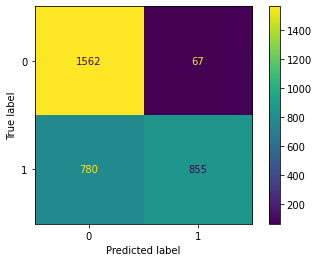

In [143]:
pc_lr_cvec_score = scores_confusion_matrix(pc_lr_cvec,'pc_lr_cvec')
pc_lr_cvec_score.head()

pc_lr_tvec accuracy: 0.7417279411764706
pc_lr_tvec recall: 0.5217125382262997
pc_lr_tvec precision: 0.9332603938730853
pc_lr_tvec Specificity: 0.9625537139349294


,train_accuracy,Accuracy,Recall,Precision,Specificity
pc_lr_tvec,0.756716,0.741728,0.521713,0.93326,0.962554


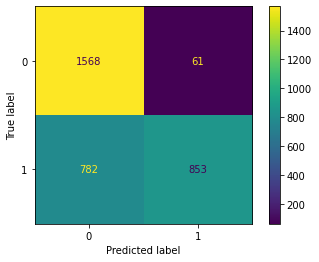

In [144]:
pc_lr_tvec_score = scores_confusion_matrix(pc_lr_tvec,'pc_lr_tvec')
pc_lr_tvec_score.head()

pc_mnb_cvec accuracy: 0.7221200980392157
pc_mnb_cvec recall: 0.5143730886850153
pc_mnb_cvec precision: 0.8815513626834381
pc_mnb_cvec Specificity: 0.9306322897483118


,train_accuracy,Accuracy,Recall,Precision,Specificity
pc_mnb_cvec,0.734078,0.72212,0.514373,0.881551,0.930632


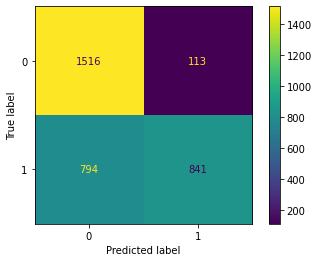

In [145]:
pc_mnb_cvec_score = scores_confusion_matrix(pc_mnb_cvec,'pc_mnb_cvec')
pc_mnb_cvec_score.head()

pc_mnb_tvec accuracy: 0.7083333333333334
pc_mnb_tvec recall: 0.5370030581039755
pc_mnb_tvec precision: 0.8182665424044734
pc_mnb_tvec Specificity: 0.8802946593001841


,train_accuracy,Accuracy,Recall,Precision,Specificity
pc_mnb_tvec,0.722608,0.708333,0.537003,0.818267,0.880295


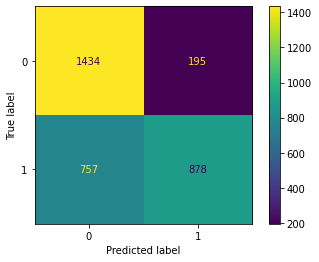

In [146]:
pc_mnb_tvec_score = scores_confusion_matrix(pc_mnb_tvec,'pc_mnb_tvec')
pc_mnb_tvec_score.head()

pc_rfc_cvec accuracy: 0.7325367647058824
pc_rfc_cvec recall: 0.5302752293577981
pc_rfc_cvec precision: 0.8919753086419753
pc_rfc_cvec Specificity: 0.9355432780847146


,train_accuracy,Accuracy,Recall,Precision,Specificity
pc_rfc_cvec,0.749623,0.732537,0.530275,0.891975,0.935543


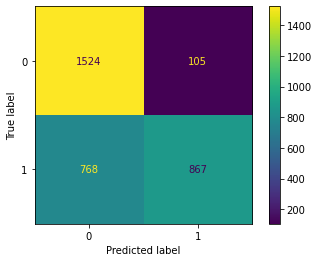

In [147]:
pc_rfc_cvec_score = scores_confusion_matrix(pc_rfc_cvec,'pc_rfc_cvec')
pc_rfc_cvec_score.head()

pc_rfc_tvec accuracy: 0.7313112745098039
pc_rfc_tvec recall: 0.5290519877675841
pc_rfc_tvec precision: 0.8899176954732511
pc_rfc_tvec Specificity: 0.9343155310006138


,train_accuracy,Accuracy,Recall,Precision,Specificity
pc_rfc_tvec,0.740869,0.731311,0.529052,0.889918,0.934316


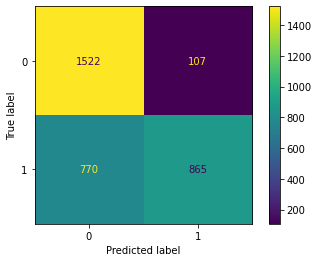

In [148]:
pc_rfc_tvec_score = scores_confusion_matrix(pc_rfc_tvec,'pc_rfc_tvec')
pc_rfc_tvec_score.head()

pt_lr_cvec accuracy: 0.8017769607843137
pt_lr_cvec recall: 0.7975535168195719
pt_lr_cvec precision: 0.8049382716049382
pt_lr_cvec Specificity: 0.8060159607120934


,train_accuracy,Accuracy,Recall,Precision,Specificity
pt_lr_cvec,0.886357,0.801777,0.797554,0.804938,0.806016


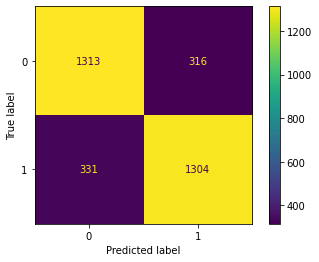

In [149]:
pt_lr_cvec_score = scores_confusion_matrix(pt_lr_cvec,'pt_lr_cvec')
pt_lr_cvec_score.head()

pt_lr_tvec accuracy: 0.8075980392156863
pt_lr_tvec recall: 0.7798165137614679
pt_lr_tvec precision: 0.8263123784834737
pt_lr_tvec Specificity: 0.8354818907305095


,train_accuracy,Accuracy,Recall,Precision,Specificity
pt_lr_tvec,0.868548,0.807598,0.779817,0.826312,0.835482


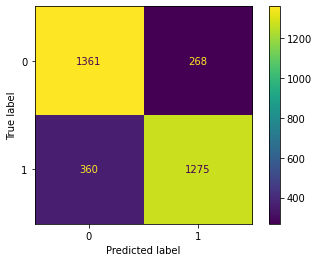

In [150]:
pt_lr_tvec_score = scores_confusion_matrix(pt_lr_tvec,'pt_lr_tvec')
pt_lr_tvec_score.head()

pt_mnb_cvec accuracy: 0.8008578431372549
pt_mnb_cvec recall: 0.8030581039755351
pt_mnb_cvec precision: 0.8001218769043267
pt_mnb_cvec Specificity: 0.7986494782074892


,train_accuracy,Accuracy,Recall,Precision,Specificity
pt_mnb_cvec,0.855418,0.800858,0.803058,0.800122,0.798649


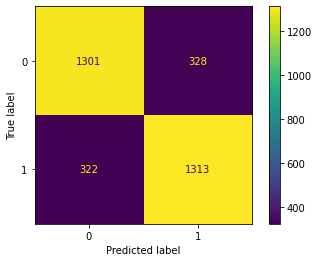

In [151]:
pt_mnb_cvec_score = scores_confusion_matrix(pt_mnb_cvec,'pt_mnb_cvec')
pt_mnb_cvec_score.head()

pt_mnb_tvec accuracy: 0.7956495098039216
pt_mnb_tvec recall: 0.7871559633027523
pt_mnb_tvec precision: 0.8013698630136986
pt_mnb_tvec Specificity: 0.8041743400859422


,train_accuracy,Accuracy,Recall,Precision,Specificity
pt_mnb_tvec,0.869756,0.79565,0.787156,0.80137,0.804174


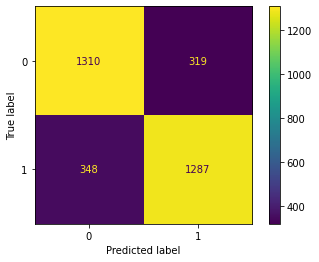

In [152]:
pt_mnb_tvec_score = scores_confusion_matrix(pt_mnb_tvec,'pt_mnb_tvec')
pt_mnb_tvec_score.head()

pt_rfc_cvec accuracy: 0.7457107843137255
pt_rfc_cvec recall: 0.5498470948012233
pt_rfc_cvec precision: 0.905337361530715
pt_rfc_cvec Specificity: 0.9422958870472683


,train_accuracy,Accuracy,Recall,Precision,Specificity
pt_rfc_cvec,0.765017,0.745711,0.549847,0.905337,0.942296


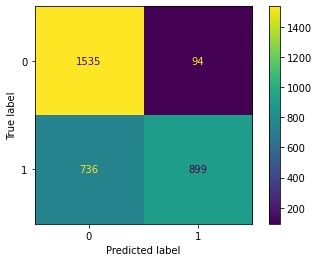

In [153]:
pt_rfc_cvec_score = scores_confusion_matrix(pt_rfc_cvec,'pt_rfc_cvec')
pt_rfc_cvec_score.head()

pt_rfc_tvec accuracy: 0.7481617647058824
pt_rfc_tvec recall: 0.5608562691131499
pt_rfc_tvec precision: 0.8981390793339863
pt_rfc_tvec Specificity: 0.9361571516267649


,train_accuracy,Accuracy,Recall,Precision,Specificity
pt_rfc_tvec,0.774525,0.748162,0.560856,0.898139,0.936157


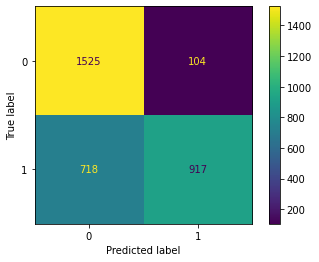

In [154]:
pt_rfc_tvec_score = scores_confusion_matrix(pt_rfc_tvec,'pt_rfc_tvec')
pt_rfc_tvec_score.head()

In [155]:
score_df_test = [pc_lr_cvec_score,pc_lr_tvec_score,pc_mnb_cvec_score,pc_mnb_tvec_score,pc_rfc_cvec_score,pc_rfc_tvec_score,pt_lr_cvec_score,pt_lr_tvec_score,pt_mnb_cvec_score,pt_mnb_tvec_score,pt_rfc_cvec_score,pt_rfc_tvec_score]

In [156]:
score_df_test= pd.concat(score_df_test)

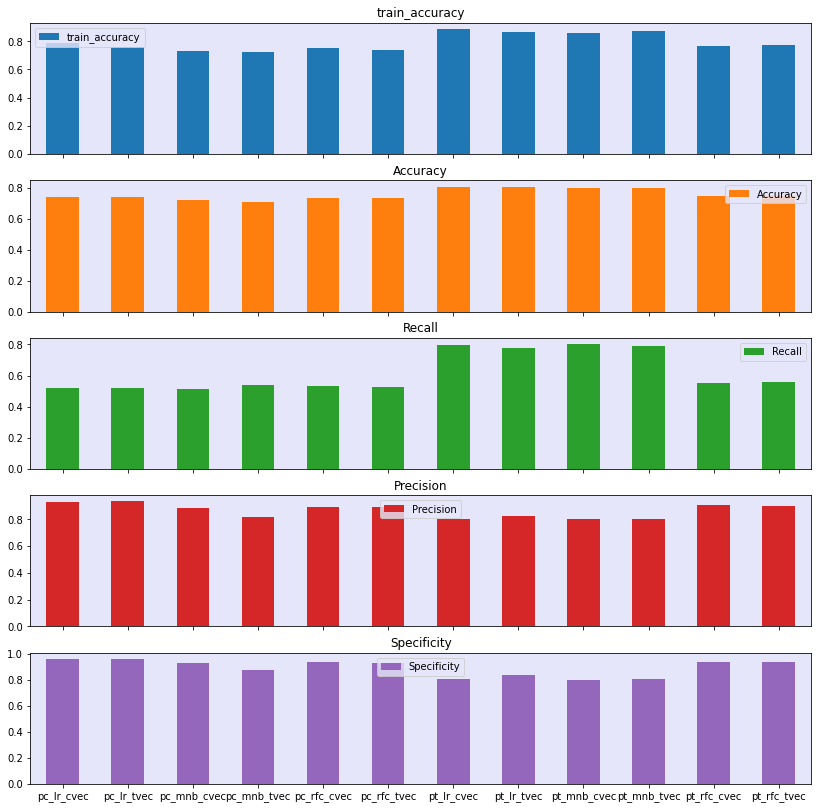

In [157]:
axes = score_df_test.plot.bar(rot=0, subplots=True, figsize=(14, 14))

In [158]:
score_df_test.head(12)

,train_accuracy,Accuracy,Recall,Precision,Specificity
pc_lr_cvec,0.785844,0.740502,0.522936,0.927332,0.958870
pc_lr_tvec,0.756716,0.741728,0.521713,0.933260,0.962554
pc_mnb_cvec,0.734078,0.722120,0.514373,0.881551,0.930632
pc_mnb_tvec,0.722608,0.708333,0.537003,0.818267,0.880295
pc_rfc_cvec,0.749623,0.732537,0.530275,0.891975,0.935543
pc_rfc_tvec,0.740869,0.731311,0.529052,0.889918,0.934316
pt_lr_cvec,0.886357,0.801777,0.797554,0.804938,0.806016
pt_lr_tvec,0.868548,0.807598,0.779817,0.826312,0.835482
pt_mnb_cvec,0.855418,0.800858,0.803058,0.800122,0.798649
pt_mnb_tvec,0.869756,0.795650,0.787156,0.801370,0.804174


## Check the most 10 important feature for rfc models

1- Transform the X_title_train using counterVectorizer with the best parameters
2- check the important features of the rfc best model
3- combine the counterVectorizered df with the important features list in one data frame

In [173]:
## get the most important features of the post title
cv_im = CountVectorizer(tokenizer = StemmerWordTokenizer(), stop_words=stop_words, ngram_range = (1, 1), min_df = 2,max_features = 2000,max_df = 0.9)
rfc2 = RandomForestClassifier(n_estimators = 750,min_samples_split = 3, min_samples_leaf = 3 , max_depth = 21)

X_title= Final_group['title']
X_title_train, X_title_test = train_test_split(X_title,test_size=0.33, random_state = 42)

In [174]:
X_train_title_cv = cv_im.fit_transform(X_title_train)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

In [175]:
df_X_train_title = pd.DataFrame(X_train_title_cv.todense(), columns=cv_im.get_feature_names())
df_X_train_title.head()

a1c  aa  ab  abdomin  abil  abl  absolut  absorb  absorbt  absorpt  academ  \
0    0   0   0        0     0    0        0       0        0        0       0   
1    0   0   0        0     0    0        0       0        0        0       0   
2    0   0   0        0     0    0        0       0        0        0       0   
3    0   0   0        0     0    0        0       0        0        0       0   
4    0   0   0        0     0    0        0       0        0        0       0   

   acceler  accept  accident  accord  account  accur  ach  achiev  acid  acn  \
0        0       0         0       0        0      0    0       0     0    0   
1        0       0         0       0        0      0    0       0     0    0   
2        0       0         0       0        0      0    0       0     0    0   
3        0       0         0       0        0      0    0       0     0    0   
4        0       0         0       0        0      0    0       0     0    0   

   act  activ  actual  ad  adapt  add  adderal  addict  addit  adequ  adhd  \
0    0      0       0   0      0    0        0       0      0      0     0   
1    0      0       0   0      0    0        0       0      0      0     0   
2    0      0       0   0      0    0        0       0      0      0     0   
3    0      0       0   0      0    0        0       0      0      0     0   
4    0      0       0   0      0    0        0       0      0      0     0   

   adjust  adob  adolesc  adopt  adult  advanc  advantag  advers  advic  \
0       0     0        0      0      0       0         0       0      0   
1       0     0        0      0      0       0         0       0      0   
2       0     0        0      0      0       0         0       0      0   
3       0     0        0      0      0       0         0       0      0   
4       0     0        0      0      0       0         0       0      0   

   advis  advoc  afe  afeti  affect  afford  afternoon  age  ago  agre  aid  \
0      0      0    0      0       0       0          0    0    0     0    0   
1      0      0    0      0       0       0          0    0    0     0    0   
2      0      0    0      0       0       0          0    0    0     0    0   
3      0      0    0      0       0       0          0    0    0     0    0   
4      0      0    0      0       0       0          0    0    0     0    0   

   aim  air  ala  alad  alcohol  aldi  alert  alexand  aliment  alkalin  \
0    0    0    0     0        0     0      0        0        0        0   
1    0    0    0     0        0     0      0        0        0        0   
2    0    0    0     0        0     0      0        0        0        0   
3    0    0    0     0        0     0      0        0        0        0   
4    0    0    0     0        0     0      0        0        0        0   

   allergi  allow  allulos  almon  almond  alpha  alreadi  alt  altern  alway  \
0        0      0        0      0       0      0        0    0       0      0   
1        0      0        0      0       0      0        0    0       0      0   
2        0      0        0      0       0      0        0    0       0      0   
3        0      0        0      0       0      0        0    0       0      0   
4        0      0        0      0       0      0        0    0       0      0   

   amaz  amazon  america  american  amino  amp  ancestr  ancient  andwich  \
0     0       0        0         0      0    0        0        0        0   
1     0       0        0         0      0    0        0        0        0   
2     0       0        0         0      0    0        0        0        0   
3     0       0        0         0      0    0        0        0        0   
4     0       0        0         0      0    0        0        0        0   

   anemia  angri  ani  anim  anniversari  annoy  anoth  answer  anti  \
0       0      0    0     0            0      0      0       0     0   
1       0      0    0     0            0      0      0       0     0   
2       0      0    0  

In [176]:
rfc2.fit(X_train_title_cv, y_train)

RandomForestClassifier(max_depth=21, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=750)

In [177]:
d = {'Column Name':df_X_train_title.columns,'Feature Importance':rfc2.feature_importances_}
fi = pd.DataFrame(d)

In [178]:
fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
1274,option,0.014617
1145,mct,0.012738
1273,optim,0.012348
365,cholesterol,0.009847
1025,label,0.009205
1848,unhealthi,0.007755
1232,non,0.007228
508,current,0.007068
511,cut,0.006925
892,hour,0.006874


In [179]:
# get the most important features of the post content
cv_im2 = CountVectorizer(tokenizer = StemmerWordTokenizer(), stop_words=stop_words, ngram_range = (1, 2), min_df = 2,max_features = 4000,max_df = 0.9)
rfc_p = RandomForestClassifier(n_estimators = 1000,min_samples_split = 7, min_samples_leaf = 3 , max_depth = 21)

X_post= Final_group['selftext']
X_post_train, X_post_test = train_test_split(X_post,test_size=0.33, random_state = 42)

In [180]:
X_train_post_cv = cv_im2.fit_transform(X_post_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'calori', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 

In [181]:
df_X_train_post = pd.DataFrame(X_train_post_cv.todense(), columns=cv_im2.get_feature_names())
df_X_train_post.head()

a1c  ab  abil  abl  abov  absolut  absorb  absorpt  accept  access  accid  \
0    0   0     0    0     0        0       0        0       0       0      0   
1    0   0     0    0     0        0       0        0       0       0      0   
2    0   0     0    0     0        0       0        0       0       0      0   
3    0   0     0    0     0        0       0        0       0       0      0   
4    0   0     0    0     0        0       0        0       0       0      0   

   accident  accommod  accomplish  accord  account  accur  ach  achiev  acid  \
0         0         0           0       0        0      0    0       0     0   
1         0         0           0       0        0      0    0       0     0   
2         0         0           0       0        0      0    0       0     0   
3         0         0           0       0        0      0    0       0     0   
4         0         0           0       0        0      0    0       0     0   

   acid reflux  acn  act  action  activ  activ level  actual  ad  adapt  add  \
0            0    0    0       0      0            0       0   0      0    0   
1            0    0    0       0      0            0       0   0      0    0   
2            0    0    0       0      0            0       0   1      0    0   
3            0    0    0       0      0            0       0   0      0    0   
4            0    0    0       0      0            0       0   0      0    0   

   addict  addit  address  adhd  adjust  admit  adopt  adult  advanc  \
0       0      0        0     0       0      0      0      0       0   
1       0      0        0     0       0      0      0      0       0   
2       0      0        0     0       0      0      0      0       0   
3       0      0        0     0       0      0      0      0       0   
4       0      0        0     0       0      0      0      0       0   

   advantag  adventur  advic  advic appreci  advic greatli  advic pertain  \
0         0         0      0              0              0              0   
1         0         0      1              0              0              0   
2         0         0      0              0              0              0   
3         0         0      0              0              0              0   
4         0         0      0              0              0              0   

   advis  advoc  af  affect  afford  afraid  afternoon  afterward  age  ago  \
0      0      0   0       0       0       0          0          0    0    0   
1      0      0   0       0       0       0          0          0    0    0   
2      0      0   0       0       0       0          0          0    0    0   
3      0      0   0       0       0       0          0          0    0    0   
4      0      0   0       0       0       0          0          0    0    0   

   ago did  ago got  ago start  ago ve  ago wa  agre  ahead  aid  aim  air  \
0        0        0          0       0       0     0      0    0    0    0   
1        0        0          0       0       0     0      0    0    0    0   
2        0        0          0       0       0     0      0    0    0    0   
3        0        0          0       0       0     0      0    0    0    0   
4        0        0          0       0       0     0      0    0    0    0   

   aka  al  ala  alcohol  aldi  allerg  allergi  allevi  allow  allulos  \
0    0   0    0        0     0       0        0       0      0        0   
1    0   0    0        0     0       0        0       0      0        0   
2    0   0    0        0     0       0        0       0      0        0   
3    0   0    0        0     0       0        0       0      0        0   
4    0   0    0        0     0       0        0       0      0        0   

   almond  almond butter  almond milk  alon  alot  alreadi  alreadi lost  \
0       0              0            0     0     0        0             0   
1       0              0            0     0     0        0             0   
2       0              0            0    

In [182]:
rfc_p.fit(X_train_post_cv, y_train)

RandomForestClassifier(max_depth=21, min_samples_leaf=3, min_samples_split=7,
                       n_estimators=1000)

In [184]:
d2 = {'Column Name':df_X_train_post.columns,'Feature Importance':rfc_p.feature_importances_}
fi_p = pd.DataFrame(d2)

In [185]:
fi_p.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
3184,start keto,0.007620
3177,start,0.007424
1137,feel,0.006242
301,benefit,0.005318
3757,wa,0.004898
1730,keto,0.004588
543,cholesterol,0.004396
3422,thi point,0.004070
1208,follow keto,0.003967
3749,vitamin,0.003898


## Conclusion
We can notice from the accuracy results for all the models we have examined that the post title, and the post content can be 
used to classify the post subreddit. The accuracy values for all the 12 models is higher than the Baseline accuracy which was 0.5009. This was the concluded result for all the proposed models.
Regarding the best model to use among the tested models, the logistic regression with the Counterectorizer with using the post title as predictor gives as the best scores as we can see from the scores figures and dataframe. 
It predicted 0.88 of the trained post correctly and 0.8 of the test posts. Also, the recall score were 0.797554 which outperform the other models.
The Precision and Specificity scores fot thc chosen model were both good comparing to the other models. If we want to choose other model, we can think about the logistic regression with the TfidfVectorizer using the post title as predictor. This model has scores near to our chosen model.
In addition to all the mentioned point regarding the choice of the model that uses Logistic regression,  Logistic regression is a very fast classification model comparing to the other model.